#**Практическое задание №1**


---

### Подготовка среды

1. Установка пакетов
2. Импорт зависимостей
3. Монтирование Google Drive
4. Задание констант

In [3]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train_my': '1mrzCtxJCQUxIlJJRCKXDH0NXMSqpILUm',
    'train_small_my': '1V2JXJ5UEtBIaur7Mj6kwDXB9SDDKrF1u',
    'train_tiny_my': '1FJVBbHIRvKhsNOZwz1XNvTcv9PrfWpm2',
    'test_my': '161F1KVMLU-wbt0-nB6nTzMNSE-7oQ7A8',
    'test_small_my': '1gu_9YX2EAmajqS1iHLsUYwm_eENbwzfR',
    'test_tiny_my': '1-UWgIiP5OxV-w5YPJorIFU0Sxc7libSg'
}

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [7]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

---

### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [8]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели. В качестве модели была выбрана предобученная модель ResNet-50


In [9]:
'''
Hyperparameters
'''

learning_rate = 0.001
num_epochs = 10
batch_size = 32
num_folds = 5

In [10]:
class Model:

    def __init__(self):
        self.num_classes = len(TISSUE_CLASSES)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_folds = num_folds

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = models.resnet18(pretrained=True)

        self.model.fc = nn.Linear(self.model.fc.in_features, self.num_classes)
        self.model = self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        pass

    def save(self, name: str):
        torch.save(self.model.state_dict(), f'/content/drive/MyDrive/{name}.pth')
        print(f"Model saved to '/content/drive/MyDrive/{name}.pth'")
        pass

    def test_load(self, name: str):
        output = '/content/drive/MyDrive/best.pth'

        self.model.load_state_dict(torch.load(output, map_location=self.device))
        self.model = self.model.to(self.device)
        self.model.eval()
        print(f'Model {name} loaded successfully')
        pass

    def load(self, name: str, key: str):
        url = f'https://drive.google.com/uc?export=download&confirm=pbef&id={key}'
        output = f'{name}.pth'
        gdown.download(url, output, quiet=False)
        self.model.load_state_dict(torch.load(output, map_location=self.device))
        self.model = self.model.to(self.device)
        self.model.eval()
        print(f'Model {name} loaded successfully')
        pass

    def train(self, dataset: Dataset):
        # Train with cross-validation
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        images = dataset.images
        labels = dataset.labels

        val_metrics = []
        balance_val_metrics = []

        #LBL2 - cross-validation
        for fold, (train_idx, val_idx) in enumerate(kf.split(images)):
            print(f"Fold {fold + 1}/{num_folds}")

            # Train and validation datasets

            #LBL1 - validation
            train_images, val_images = images[train_idx], images[val_idx]
            train_labels, val_labels = labels[train_idx], labels[val_idx]

            self.model.train()

            for epoch in range(num_epochs):
                epoch_loss = 0.0

                n_batches = len(train_images) // batch_size
                for _ in range(n_batches):
                    batch_images, batch_labels = dataset.random_batch_with_labels(batch_size)

                    # Data-tensor transform
                    batch_images = torch.tensor(batch_images).float().permute(0, 3, 1, 2).to(self.device) / 255.0
                    batch_labels = torch.tensor(batch_labels).long().to(self.device)

                    self.optimizer.zero_grad()

                    outputs = self.model(batch_images)
                    loss = self.criterion(outputs, batch_labels)

                    # Backward
                    loss.backward()
                    self.optimizer.step()

                    # Sum loss
                    epoch_loss += loss.item()

                #LBL4 - show info
                print(f"  Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / n_batches:.4f}")

            val_accuracy, val_balanced_accuracy = self.evaluate(val_images, val_labels)
            val_metrics.append(val_accuracy)
            balance_val_metrics.append(val_balanced_accuracy)
            #LBL4 - show info
            print(f"Validation Accuracy for fold {fold + 1}: {val_accuracy:.4f}")
            print(f"Validation Balanced Accuracy for fold {fold + 1}: {val_balanced_accuracy:.4f}")

            #LBL3 - model auto-save
            self.save(f"model_fold_{fold + 1}.pth")
            print(f"Model saved to model_fold_{fold + 1}.pth")

        # Plot visualization
        epochs = range(1, self.num_folds + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_metrics, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} - Validation Accuracy')
        plt.xlabel('Folds')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, balance_val_metrics, label='Validation Balanced Accuracy')
        plt.title(f'Fold {fold + 1} - Validation Balanced Accuracy')
        plt.xlabel('Folds')
        plt.ylabel('Balanced Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

        pass

    def evaluate(self, images, labels):
        self.model.eval()
        all_predictions = []

        for img in images:
            pred_label = self.test_on_image(img)
            all_predictions.append(pred_label)

        accuracy = Metrics.accuracy(labels.tolist(), all_predictions)
        balanced_accuracy = Metrics.accuracy_balanced(labels.tolist(), all_predictions)
        return accuracy, balanced_accuracy

    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        image_tensor = torch.tensor(img).float().permute(2, 0, 1).unsqueeze(0).to(self.device) / 255.0
        self.model.eval()

        with torch.no_grad():
            output = self.model(image_tensor)
            _, predicted_label = torch.max(output, 1)

        return predicted_label.item()


---
### Классификация изображений

In [11]:
d_train = Dataset('train_my')
d_test = Dataset('test_my')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1mrzCtxJCQUxIlJJRCKXDH0NXMSqpILUm
To: /content/train_my.npz
100%|██████████| 2.10G/2.10G [00:22<00:00, 94.7MB/s]


Loading dataset train_my from npz.
Done. Dataset train_my consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=161F1KVMLU-wbt0-nB6nTzMNSE-7oQ7A8
To: /content/test_my.npz
100%|██████████| 525M/525M [00:08<00:00, 60.5MB/s]


Loading dataset test_my from npz.
Done. Dataset test_my consists of 4500 images.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1/5
  Epoch 1/10, Loss: 0.3987
  Epoch 2/10, Loss: 0.2109
  Epoch 3/10, Loss: 0.1665
  Epoch 4/10, Loss: 0.1440
  Epoch 5/10, Loss: 0.1232
  Epoch 6/10, Loss: 0.0913
  Epoch 7/10, Loss: 0.1003
  Epoch 8/10, Loss: 0.0873
  Epoch 9/10, Loss: 0.0668
  Epoch 10/10, Loss: 0.0722
Validation Accuracy for fold 1: 0.9433
Validation Balanced Accuracy for fold 1: 0.9424
Model saved to '/content/drive/MyDrive/model_fold_1.pth.pth'
Model saved to model_fold_1.pth
Fold 2/5
  Epoch 1/10, Loss: 0.0561
  Epoch 2/10, Loss: 0.0647
  Epoch 3/10, Loss: 0.0509
  Epoch 4/10, Loss: 0.0561
  Epoch 5/10, Loss: 0.0579
  Epoch 6/10, Loss: 0.0327
  Epoch 7/10, Loss: 0.0350
  Epoch 8/10, Loss: 0.0399
  Epoch 9/10, Loss: 0.0372
  Epoch 10/10, Loss: 0.0337
Validation Accuracy for fold 2: 0.7939
Validation Balanced Accuracy for fold 2: 0.7969
Model saved to '/content/drive/MyDrive/model_fold_2.pth.pth'
Model saved to model_fold_2.pth
Fold 3/5
  Epoch 1/10, Loss: 0.0530
  Epoch 2/10, Loss: 0.0165
  Epoch 3/10, Los

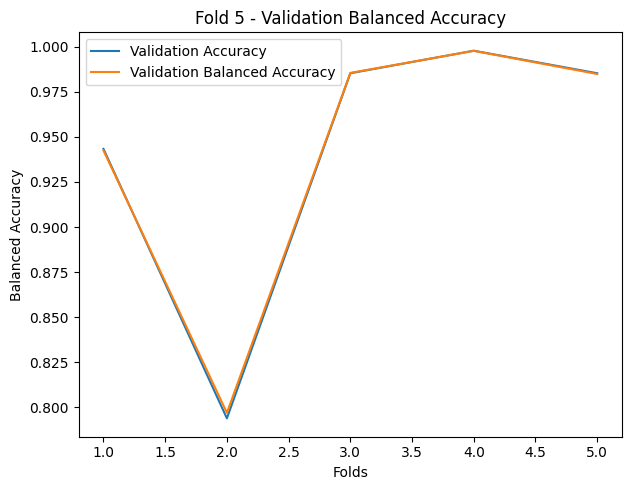

Model saved to '/content/drive/MyDrive/best.pth'


  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for Trained model Prediction results:
	 accuracy 0.9424:
	 balanced accuracy 0.9424:
Test load
Model best loaded successfully


<ipython-input-10-4aaf169f8ecb>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(output, map_location=self.device))


  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for Loaded model Prediction results:
	 accuracy 0.9424:
	 balanced accuracy 0.9424:


In [12]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')

    pred = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels[:len(pred)], pred, "Trained model Prediction results")

print("Test load")
model.test_load('best')
pred = model.test_on_dataset(d_test)
Metrics.print_all(d_test.labels[:len(pred)], pred, "Loaded model Prediction results")

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [15]:
final_model = Model()
final_model.load('best', '1U5dQx50pTZA_IZ9hcY1-3uEbjmzULcfI')
d_test_tiny = Dataset('test_tiny_my')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1U5dQx50pTZA_IZ9hcY1-3uEbjmzULcfI
To: /content/best.pth
100%|██████████| 44.8M/44.8M [00:00<00:00, 149MB/s]
<ipython-input-10-4aaf169f8ecb>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the l

Model best loaded successfully


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1-UWgIiP5OxV-w5YPJorIFU0Sxc7libSg
To: /content/test_tiny_my.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 233MB/s]

Loading dataset test_tiny_my from npz.
Done. Dataset test_tiny_my consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.8778:
	 balanced accuracy 0.8778:


Отмонтировать Google Drive.

In [16]:
drive.flush_and_unmount()